In [4]:
import yaml
import numpy as np
from TraceSimulator import LongTraceSimulator
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import fftconvolve
from OptimumFilter import *


def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('/home/dwong/DELight_mtr/trigger_study/archive/wk11/config.yaml')
lts = LongTraceSimulator(config)


sampling_frequency = 3906250
template = np.load("/home/dwong/DELight_mtr/trigger_study/wk15/templates/sub_ch_template.npy")
noise_psd = np.load("/home/dwong/DELight_mtr/templates/noise_psd_from_MMC.npy")
sub_of = OptimumFilter(template, noise_psd, sampling_frequency)


In [5]:
trace, idx= lts.generate(
            E=70000,
            x=-94, y=0, z=-1800,
            no_noise=False,
            type_recoil='ER',
            quantize=True,
            phonon_only=False,
            long_trace_samples = 250000
        )
trace = trace[0]

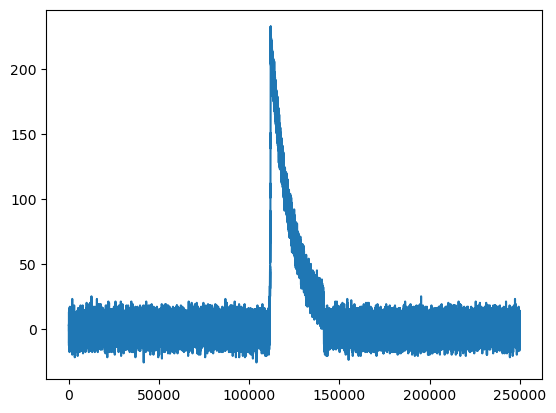

In [6]:
example = trace[7]
plt.plot(example)

In [7]:
from joblib import Parallel, delayed
import numpy as np

trace = example  # assuming example is a 1D array of length 50000
window_size = 32768
num_windows = len(trace) - window_size + 1

def fit_window(i):
    segment = trace[i:i+window_size]
    return sub_of.fit(segment)

results = Parallel(n_jobs=-1)(delayed(fit_window)(i) for i in range(num_windows))
ampl_arr, chisq_arr = map(np.array, zip(*results))


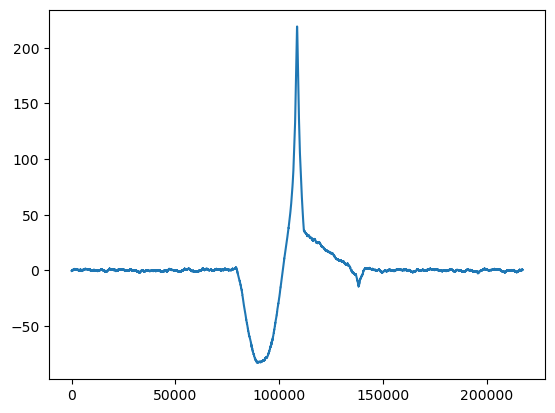

In [8]:
plt.plot(ampl_arr)

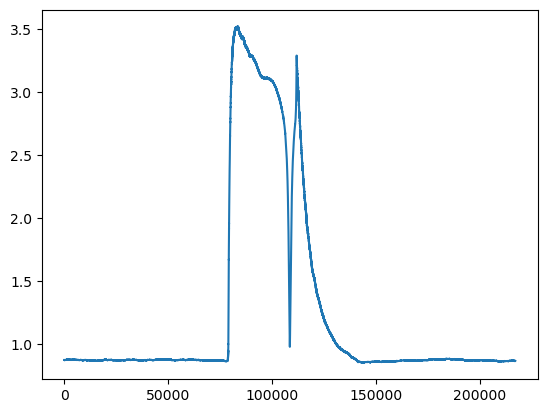

In [9]:
plt.plot(chisq_arr)

In [10]:
idx

108616

In [11]:
np.savez("validation_trace.npz", raw=example, ampl=ampl_arr, chisq=chisq_arr, inject=idx)
